# Hugging Face with ART

In this notebook we will go over how to use the Hugging Face API with ART. This can enable us to train robust foundation models which act over images. 

Currently this is a developing feature, and so not all ART tools are supported. Further tools and development is planned. As of ART 1.16 we support: 
* Using a Pytorch backend.
* Evasion attacks and defences on classical classification tasks such as image classification, but not tasks such as object detection.

If you have a use case that is not supported (or find a bug in this new feature!) please raise an issue on ART.

In addition to the core ART dependencies you will need to install Pytorch and the Transformers library:

`pip install torch torchvision`

`pip install transformers`

This notebook was tested with the transformers library version 4.30.2, and torch==2.1.0/torchvision==0.16.0

Let's look at how we can use ART to secure Hugging Face models!


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import transformers

from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.defences.trainer import AdversarialTrainerMadryPGD
from art.utils import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# We will use a small subset of the CIFAR-10 dataset

(x_train, y_train), (_, _), _, _ = load_dataset('cifar10')
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
y_train = np.argmax(y_train, axis=1)

classes = np.unique(y_train)
samples_per_class = 100

x_subset = []
y_subset = []

for c in classes:
    indices = y_train == c
    x_subset.append(x_train[indices][:samples_per_class])
    y_subset.append(y_train[indices][:samples_per_class])

x_subset = np.concatenate(x_subset)
y_subset = np.concatenate(y_subset)

print(f'x_subset:', x_subset.dtype, x_subset.shape)
print(f'y_subset:', y_subset.dtype, y_subset.shape)

x_subset: float32 (1000, 3, 32, 32)
y_subset: int64 (1000,)


## Regular Training with ART

We will first see how to load a model into ART's HuggingFaceClassifierPyTorch, train it, and attack it with PGD.

In [21]:
# The HuggingFaceClassifierPyTorch follows broadly the same API as the PyTorchClassifier
# So we can supply the loss function, the input shape of the data we will supply, the optimizer, etc.
# Note, frequently we will be performing fine-tuning or transfer learning with vision transformers and 
# so we may be fine-tuning on differently sized inputs. 
# The input_shape argument refers to the shape of the supplied input data which may be different to 
# the shape required by the model.
# To handle this HuggingFaceClassifierPyTorch has an extra argument of processor which will act on 
# every batch to process the data into the correct form required by the supplied model.
# This needs to be manually specified by the user. For many attacks and defences to work it needs to be a 
# differentiable function.
# Here the processor is a simple upsampler to enlarge the cifar images into the right size.

model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0, 1),
    processor=upsampler
)

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = './state_dicts/deit_cifar_base_model.pt'
if os.path.isfile(model_checkpoint_path):
    hf_model.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    hf_model.fit(x_subset, y_subset, nb_epochs=5)
    torch.save(hf_model.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

loaded model checkpoint


In [7]:
outputs = hf_model.predict(x_subset)
acc = np.mean(np.argmax(outputs, axis=1) == y_subset)
print('clean accuracy:', acc)

clean accuracy: 0.907


In [8]:
# load adversarial samples if they already exist, otherwise generate them

adv_samples_path = './state_dicts/x_adv_base.npy'
if os.path.isfile(adv_samples_path):
    x_adv = np.load(adv_samples_path)
else:
    attacker = ProjectedGradientDescentPyTorch(hf_model, eps=8/255, eps_step=1/255)
    x_adv = attacker.generate(x_subset)
    np.save(adv_samples_path, x_adv)

outputs = hf_model.predict(x_adv)
acc = np.mean(np.argmax(outputs, axis=1) == y_subset)
print('adversarial accuracy:', acc)

adversarial accuracy: 0.057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


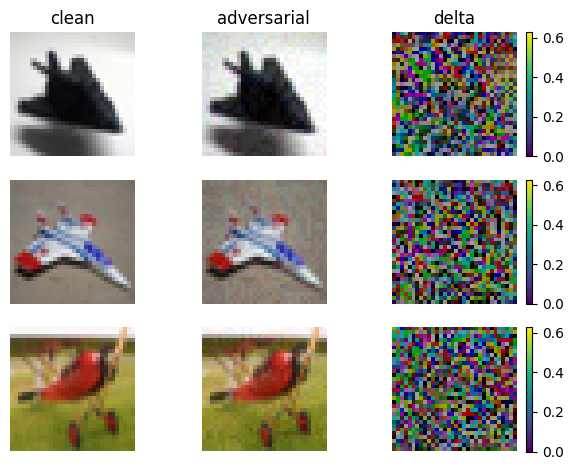

In [9]:
# We can display the adversarial examples to highlight the added perturbation to the original sample.
x_test_adv_robust = np.moveaxis(x_adv, [1], [3])
x_test = np.moveaxis(x_subset, [1], [3])
delta = ((x_test - x_test_adv_robust) + 8/255) * 10 # shift to have min 0 and make perturbations 10x larger to visualize them.

fig, axs = plt.subplots(3, 3)
for i in range(3):
    axs[i, 0].imshow(x_test[i])
    axs[i, 0].axis('off')
    axs[i, 1].imshow(x_test_adv_robust[i])
    axs[i, 1].axis('off')
    im = axs[i, 2].imshow(delta[i])
    axs[i, 2].axis('off')
    fig.colorbar(im)

axs[0, 0].set_title('clean')
axs[0, 1].set_title('adversarial')
axs[0, 2].set_title('delta')
plt.tight_layout()

## Adversarial Training with ART

Now, rather than using regular training, we employ robust PGD training and evaluate the robust model.

In [10]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0, 1),
    processor=upsampler
)

trainer = AdversarialTrainerMadryPGD(
    classifier=hf_model,
    nb_epochs=10,
    eps=8/255,
    eps_step=1/255,
    max_iter=10
)

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = './state_dicts/deit_cifar_robust_model.pt'
if os.path.isfile(model_checkpoint_path):
    trainer.classifier.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    trainer.fit(x_subset, y_subset, nb_epochs=5)
    torch.save(trainer.classifier.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

loaded model checkpoint


In [12]:
outputs = trainer.classifier.predict(x_subset)
acc = np.mean(np.argmax(outputs, axis=1) == y_subset)
print('clean accuracy:', acc)

clean accuracy: 0.784


In [13]:
# load adversarial samples if they already exist, otherwise generate them

adv_samples_path = './state_dicts/x_adv_robust.npy'
if os.path.isfile(adv_samples_path):
    x_adv = np.load(adv_samples_path)
else:
    attacker = ProjectedGradientDescentPyTorch(trainer.classifier, eps=8/255, eps_step=1/255)
    x_adv = attacker.generate(x_subset)
    np.save(adv_samples_path, x_adv)

outputs = trainer.classifier.predict(x_adv)
acc = np.mean(np.argmax(outputs, axis=1) == y_subset)
print('adversarial accuracy:', acc)

adversarial accuracy: 0.569


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


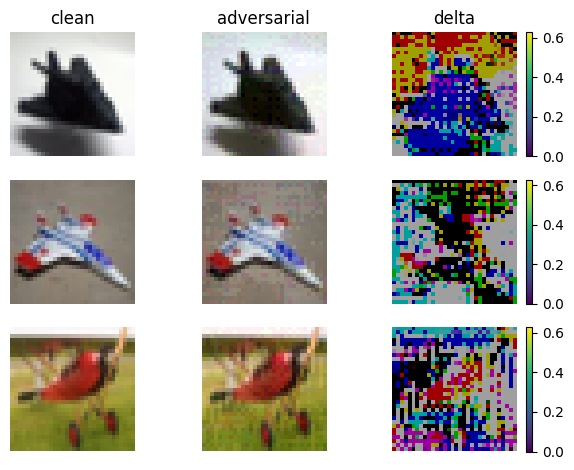

In [14]:
# We can display the adversarial examples to highlight the added perturbation to the original sample.
x_test_adv_robust = np.moveaxis(x_adv, [1], [3])
x_test = np.moveaxis(x_subset, [1], [3])
delta = ((x_test - x_test_adv_robust) + 8/255) * 10 # shift to have min 0 and make perturbations 10x larger to visualize them.

fig, axs = plt.subplots(3, 3)
for i in range(3):
    axs[i, 0].imshow(x_test[i])
    axs[i, 0].axis('off')
    axs[i, 1].imshow(x_test_adv_robust[i])
    axs[i, 1].axis('off')
    im = axs[i, 2].imshow(delta[i])
    axs[i, 2].axis('off')
    fig.colorbar(im)

axs[0, 0].set_title('clean')
axs[0, 1].set_title('adversarial')
axs[0, 2].set_title('delta')
plt.tight_layout()

# PyTorch Image Models (timm)

PyTorch Image Models (timm) is a poular repository for SOTA implementations of image models and Hugging Face is hosting many of the models and weights.

We can use timm models here with the same wrapper.

To run this part of the notebook we need to install the timm library

`pip install timm`

This notebook was ran with timm==0.9.8

In [15]:
import timm

# We can also try different architectures,
# for example one of the most popular models on Huggingface is the resnet-50
model = timm.create_model('resnet50.a1_in1k', pretrained=True)
upsampler = torch.nn.Upsample(scale_factor=7, mode='nearest')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

timm_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    input_shape=(3, 32, 32),
    nb_classes=10,
    optimizer=optimizer,
    clip_values=(0, 1),
    processor=upsampler
)

In [16]:
timm_model.fit(x_subset[:2], y_subset[:2], nb_epochs=1)

In [17]:
output = timm_model.predict(x_subset[:2])
preds = np.argmax(output, axis=1)
preds.shape

(2,)

## Custom Hugging Face Models

We can also create custom Hugging Face models using a custom configutation. The ART wrapper will allow us to use the model in the same way.

In [18]:
# We can also use the interface so supply custom Hugging Face models.
# Here is a simple example for running a toy neural network classifier.

from transformers.modeling_utils import PreTrainedModel
from transformers.configuration_utils import PretrainedConfig
from transformers.modeling_outputs import ImageClassifierOutput


class ModelConfig(PretrainedConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Model(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.conv = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fullyconnected = torch.nn.Linear(6272, 10)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(-1, 6272)
        x = self.fullyconnected(x)
        return ImageClassifierOutput(logits=x)


config = ModelConfig()
model = Model(config=config)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
simple_hf_classifier = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    clip_values=(0, 1),
    processor=None  # No processor is needed as the data is of the correct size for the model.
)

In [19]:
simple_hf_classifier.fit(x_subset, y_subset, nb_epochs=5)

In [20]:
outputs = simple_hf_classifier.predict(x_subset)
acc = np.mean(np.argmax(outputs, axis=1) == y_subset)
print('clean accuracy:', acc)

clean accuracy: 0.411
